# Machine Learning: Models & Algorithms - Project

## Creditworthiness prediction for credit card issuance

As a data scientist recently hired by Pro National Bank, your initial task is to create a model capable of estimating the creditworthiness of customers. This model aims to assist the dedicated team in deciding whether to accept or reject credit card issuance requests.

For this purpose, you have been provided with anonymized data of customers who have already obtained a credit card, including the status of their monthly debt. The data is organized into two CSV files.

Your model should be designed to provide the team with guidance on whether to approve or deny a credit card request for a given customer.

Bonus:
In cases where a customer's credit card application is denied, the team requires the ability to provide the customer with a clear explanation. This means that your model should generate easily interpretable indications to offer insights into the decision-making process.

## Datasets description

Dataset "application_record.csv":

    - ID: Client number
    - CODE_GENDER: Gender
    - FLAG_OWN_CAR: Is there a car
    - FLAG_OWN_REALTY: Is there a property
    - CNT_CHILDER: Number of children
    - AMT_INCOME_TOTAL: Annual income
    - NAME_INCOME_TYPE: Income category
    - NAME_EDUCATION_TYPE: Education level
    - NAME_FAMILY_STATUS: Marital status
    - NAME_HOUSING_TYPE: Way of living
    - DAYS_BIRTH: Birthday (Count backwards from current day (0), -1 means yesterday)
    - DAYS_EMPLOYED: Start date of employment (Count backwards from current day (0). If positive, it means the person currently unemployed
    - FLAG_MOBILE: Is there a mobile phone
    - FLAG_WORK_PHONE: Is there a work phone
    - FLAG_PHONE: Is there a phone
    - FLAG_EMAIL: Is there an email
    - OCCUPATION_TYPE: Occupation
    - CNT_FAM_MEMBERS: Family size
    
Dataset "credit_record.csv":

    - ID: Client number
    - MONTHS_BALANCE: Record month (The month of the extracted data is the starting point, backwards, 0 is current month, -1 is the previous month, and so on)
    - STATUS: 0: 1-29 days past due, 1: 30-59 days past due, 2: 60-89 days overdue, 3: 90-119 days overdue, 4: 120-149 days ovedue, 5: Overdue or bad debts, write-offs for more than 150days, C: paid off that month, X: No loan fo the month

## Analysis: Modeling and Assessment of Credit Risk


The target variable was not explained, but the possible target should be feature STATUS that rapresents how to clients meet deadlines in terms of pay in time or late.
It should be a good metric to be used to choose if the client could have a credit card or not.

- X: client without finance history - Class: 0
- C: could be a client reliable - Class: 1
- 0 to 5:  could be a client not unreliable - Class: 2

In this solution, no compromises are present and then the client are classified as reliable and not reliable.
It keeps in a different class only the client that hasn't a financial history and let to the credits istitution to decide to release or not the credit card.

Metrics chosen for the model evaluation are: 

- F1-score
- Precision
- Recall
- Accuracy

In conclusion, the classification report of skitlearn.

### Import modules

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss, classification_report, confusion_matrix, accuracy_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

### Define constant

In [2]:
# System path where to find the dataset
PATH_TO_DATASET = "C:\\Users\\39366\\Downloads\\credit_approval\\"

# Random seed
RANDOM_SEED = 0

### Define functions

In [49]:
# Explain the model predictions by sample_id
def explain_model_prediction(model, sample_id):
    # Create LIME explainer
    explainer = LimeTabularExplainer(X_train, feature_names=df.columns)

    # Explain model decision using sample_id
    exp = explainer.explain_instance(X_test[sample_id], model.predict_proba)

    # Display the reasons
    exp.show_in_notebook()

# Calculate the class counts for feature
def print_class_counts(feature_name, feature_series):
    print(f"\nCount of class {feature_name}: \n{feature_series.value_counts()} \n----------")

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_precision=True, show_recall=True):

  cm = confusion_matrix(y_true, 
                        y_pred) # tn, fp, fn, tp 

  df_cm = pd.DataFrame(cm,
                       index = labels,
                       columns = ["Predicted "+labels[0],"Predicted "+labels[1]])
    
  sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

# Function used to plot histograms for dataset features
def plot_histogram(X, feature_name):
    plt.hist(X, bins=20)
    plt.xlabel(f'{feature_name}')
    plt.ylabel('Frequency')
    plt.title(f'{feature_name} Distribution ')
    plt.show()

# Map categorical columns with specific encoder
def encode_binary_variables(dataset, dict_encoder):
    """
    Map categorical columns in a DataFrame using a specified encoder dictionary.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing the columns to be mapped.
    - column_encoder (dict): Dictionary with column names as keys and encoder dictionaries as values.

    Returns:
    - pandas.DataFrame: DataFrame with mapped categorical columns.
    """
    for key, encoder in dict_encoder.items():
        dataset[key] = dataset[key].map(encoder)
        
    return dataset

# Apply One-Hot-Encoding to columns
def create_dummy_variables(dataset, columns):
    """
    Create dummy variables for specified columns in a DataFrame.

    Parameters:
    - dataset (pandas.DataFrame): DataFrame for which to create dummy variables.
    - columns (list): List of column names for which to create dummy variables.

    Returns:
    - pandas.DataFrame: DataFrame with dummy variables.
    """
    df_dummies = pd.get_dummies(dataset, columns=columns, prefix=columns)
    
    return df_dummies

### Data Pre-Processing

#### Import datasets

In [4]:
# Read the datasets (CSV)
df_application = pd.read_csv(PATH_TO_DATASET + "application_record.csv", index_col=0)
df_credit = pd.read_csv(PATH_TO_DATASET + "credit_record.csv", index_col=0)

In [5]:
# Show application dataset
df_application.head()

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                               
5008804           M            Y               Y             0   
5008805           M            Y               Y             0   
5008806           M            Y               Y             0   
5008808           F            N               Y             0   
5008809           F            N               Y             0   

         AMT_INCOME_TOTAL      NAME_INCOME_TYPE  \
ID                                                
5008804          427500.0               Working   
5008805          427500.0               Working   
5008806          112500.0               Working   
5008808          270000.0  Commercial associate   
5008809          270000.0  Commercial associate   

                   NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
ID                                                             
5008804               Higher education        Civil marriage   
5008805               Higher education        Civil marriage   
5008806  Secondary / secondary special               Married   
5008808  Secondary / secondary special  Single / not married   
5008809  Secondary / secondary special  Single / not married   

         NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  \
ID                                                                  
5008804   Rented apartment      -12005          -4542           1   
5008805   Rented apartment      -12005          -4542           1   
5008806  House / apartment      -21474          -1134           1   
5008808  House / apartment      -19110          -3051           1   
5008809  House / apartment      -19110          -3051           1   

         FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
ID                                                                 
5008804                1           0           0             NaN   
5008805                1           0           0             NaN   
5008806                0           0           0  Security staff   
5008808                0           1           1     Sales staff   
5008809                0           1           1     Sales staff   

         CNT_FAM_MEMBERS  
ID                        
5008804              2.0  
5008805              2.0  
5008806              2.0  
5008808              1.0  
5008809              1.0

#### Explore datasets and join them

In [6]:
# Show credit dataset
df_credit.head()

MONTHS_BALANCE STATUS
ID                            
5001711               0      X
5001711              -1      0
5001711              -2      0
5001711              -3      0
5001712               0      C

In [7]:
# Show dataset info
df_application.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438557 entries, 5008804 to 6842885
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CODE_GENDER          438557 non-null  object 
 1   FLAG_OWN_CAR         438557 non-null  object 
 2   FLAG_OWN_REALTY      438557 non-null  object 
 3   CNT_CHILDREN         438557 non-null  int64  
 4   AMT_INCOME_TOTAL     438557 non-null  float64
 5   NAME_INCOME_TYPE     438557 non-null  object 
 6   NAME_EDUCATION_TYPE  438557 non-null  object 
 7   NAME_FAMILY_STATUS   438557 non-null  object 
 8   NAME_HOUSING_TYPE    438557 non-null  object 
 9   DAYS_BIRTH           438557 non-null  int64  
 10  DAYS_EMPLOYED        438557 non-null  int64  
 11  FLAG_MOBIL           438557 non-null  int64  
 12  FLAG_WORK_PHONE      438557 non-null  int64  
 13  FLAG_PHONE           438557 non-null  int64  
 14  FLAG_EMAIL           438557 non-null  int64  
 15  OCCUPATION

In [8]:
# Show dataset info
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 5001711 to 5150487
Data columns (total 2 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   MONTHS_BALANCE  1048575 non-null  int64 
 1   STATUS          1048575 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.0+ MB


In [9]:
# Join the credits dataset with application dataset
# in order to have a unique dataset with all information about the client
df = pd.merge(df_application, df_credit, on='ID', how="inner")

# Show new dataset
df

# The new dataset trace the credit situation for each client and then it is possible
# to have a storic information about the client and his behavior to pay the debts.

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                               
5008804           M            Y               Y             0   
5008804           M            Y               Y             0   
5008804           M            Y               Y             0   
5008804           M            Y               Y             0   
5008804           M            Y               Y             0   
...             ...          ...             ...           ...   
5150337           M            N               Y             0   
5150337           M            N               Y             0   
5150337           M            N               Y             0   
5150337           M            N               Y             0   
5150337           M            N               Y             0   

         AMT_INCOME_TOTAL NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
ID                                                                          
5008804          427500.0          Working               Higher education   
5008804          427500.0          Working               Higher education   
5008804          427500.0          Working               Higher education   
5008804          427500.0          Working               Higher education   
5008804          427500.0          Working               Higher education   
...                   ...              ...                            ...   
5150337          112500.0          Working  Secondary / secondary special   
5150337          112500.0          Working  Secondary / secondary special   
5150337          112500.0          Working  Secondary / secondary special   
5150337          112500.0          Working  Secondary / secondary special   
5150337          112500.0          Working  Secondary / secondary special   

           NAME_FAMILY_STATUS NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
ID                                                                           
5008804        Civil marriage  Rented apartment      -12005          -4542   
5008804        Civil marriage  Rented apartment      -12005          -4542   
5008804        Civil marriage  Rented apartment      -12005          -4542   
5008804        Civil marriage  Rented apartment      -12005          -4542   
5008804        Civil marriage  Rented apartment      -12005          -4542   
...                       ...               ...         ...            ...   
5150337  Single / not married  Rented apartment       -9188          -1193   
5150337  Single / not married  Rented apartment       -9188          -1193   
5150337  Single / not married  Rented apartment       -9188          -1193   
5150337  Single / not married  Rented apartment       -9188          -1193   
5150337  Single / not married  Rented apartment       -9188          -1193   

         FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
ID                                                                             
5008804           1                1           0           0             NaN   
5008804           1                1           0           0             NaN   
5008804           1                1           0           0             NaN   
5008804           1                1           0           0             NaN   
5008804           1                1           0           0             NaN   
...             ...              ...         ...         ...             ...   
5150337           1                0           0           0        Laborers   
5150337           1                0           0           0        Laborers   
5150337           1                0           0           0        Laborers   
5150337           1                0           0           0        Laborers   
5150337           1                0           0           0        Laborers   

         CNT_FAM_MEMBERS  MONTHS_BALANCE STATUS  
ID                                       

In [10]:
# Show the classes of STATUS variable
print_class_counts("STATUS", df["STATUS"])


Count of class STATUS: 
C    329536
0    290654
X    145950
1      8747
5      1527
2       801
3       286
4       214
Name: STATUS, dtype: int64 
----------


In [11]:
# Rename the FLAG_MOBIL columns for type error
df = df.rename(columns={'FLAG_MOBIL':'FLAG_MOBILE'})

In [12]:
# The final dataset contains for each client (ID) more than one record
# related to the opened debts and related status. In order to manage
# the duplication of these records and then use the dataset to train 
# a model, is good to unify the records making as final STATUS
# the mode of feature for every single client in order to have
# one record that rapresents the reliability of client.

# Substitution of mode for STATUS feature for each client
# Groupby client ID the STATUS feature calculating the mode ofr each client
mode_status_per_client = df.groupby('ID')['STATUS'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

# Merge the results of Groupby with the main dataset
df = pd.merge(df, mode_status_per_client, on='ID', how='left', suffixes=('', '_MODE'))

# Drop the duplicated record in order to keep one record for each client
df = df.drop_duplicates(subset='ID', keep='last')

# Set the index of dataset by client ID
df.set_index('ID', inplace=True)

# Show new dataset
df

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                               
5008804           M            Y               Y             0   
5008805           M            Y               Y             0   
5008806           M            Y               Y             0   
5008808           F            N               Y             0   
5008809           F            N               Y             0   
...             ...          ...             ...           ...   
5149828           M            Y               Y             0   
5149834           F            N               Y             0   
5149838           F            N               Y             0   
5150049           F            N               Y             0   
5150337           M            N               Y             0   

         AMT_INCOME_TOTAL      NAME_INCOME_TYPE  \
ID                                                
5008804          427500.0               Working   
5008805          427500.0               Working   
5008806          112500.0               Working   
5008808          270000.0  Commercial associate   
5008809          270000.0  Commercial associate   
...                   ...                   ...   
5149828          315000.0               Working   
5149834          157500.0  Commercial associate   
5149838          157500.0             Pensioner   
5150049          283500.0               Working   
5150337          112500.0               Working   

                   NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
ID                                                             
5008804               Higher education        Civil marriage   
5008805               Higher education        Civil marriage   
5008806  Secondary / secondary special               Married   
5008808  Secondary / secondary special  Single / not married   
5008809  Secondary / secondary special  Single / not married   
...                                ...                   ...   
5149828  Secondary / secondary special               Married   
5149834               Higher education               Married   
5149838               Higher education               Married   
5150049  Secondary / secondary special               Married   
5150337  Secondary / secondary special  Single / not married   

         NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBILE  \
ID                                                                   
5008804   Rented apartment      -12005          -4542            1   
5008805   Rented apartment      -12005          -4542            1   
5008806  House / apartment      -21474          -1134            1   
5008808  House / apartment      -19110          -3051            1   
5008809  House / apartment      -19110          -3051            1   
...                    ...         ...            ...          ...   
5149828  House / apartment      -17348          -2420            1   
5149834  House / apartment      -12387          -1325            1   
5149838  House / apartment      -12387          -1325            1   
5150049  House / apartment      -17958           -655            1   
5150337   Rented apartment       -9188          -1193            1   

         FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
ID                                                                 
5008804                1           0           0             NaN   
5008805                1           0           0             NaN   
5008806                0           0           0  Security staff   
5008808                0           1           1     Sales staff   
5008809                0           1           1     Sales staff   
...                  ...         ...         ...             ...   
5149828                0           0           0        Managers   
5149834                0           1           1  Medicine staff   
5149838                0           1           1  Medicine st

In [13]:
# A new feature "RELIABILITY_ESTIMATED" added that rapresents the 
# prevalent class for each client and then the estimated reliability 
# for credit card release.

# The classes are made as described on top of document

# Class mapping
reliability_mapping = {'X': 0, 'C': 1, '0': 2, '1': 2, '2': 2, '3': 2, '4': 2, '5': 2}

# Creation of new target variable
df['STATUS_MODE'] = df['STATUS_MODE'].map(reliability_mapping)

# Show new dataset
df

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                               
5008804           M            Y               Y             0   
5008805           M            Y               Y             0   
5008806           M            Y               Y             0   
5008808           F            N               Y             0   
5008809           F            N               Y             0   
...             ...          ...             ...           ...   
5149828           M            Y               Y             0   
5149834           F            N               Y             0   
5149838           F            N               Y             0   
5150049           F            N               Y             0   
5150337           M            N               Y             0   

         AMT_INCOME_TOTAL      NAME_INCOME_TYPE  \
ID                                                
5008804          427500.0               Working   
5008805          427500.0               Working   
5008806          112500.0               Working   
5008808          270000.0  Commercial associate   
5008809          270000.0  Commercial associate   
...                   ...                   ...   
5149828          315000.0               Working   
5149834          157500.0  Commercial associate   
5149838          157500.0             Pensioner   
5150049          283500.0               Working   
5150337          112500.0               Working   

                   NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
ID                                                             
5008804               Higher education        Civil marriage   
5008805               Higher education        Civil marriage   
5008806  Secondary / secondary special               Married   
5008808  Secondary / secondary special  Single / not married   
5008809  Secondary / secondary special  Single / not married   
...                                ...                   ...   
5149828  Secondary / secondary special               Married   
5149834               Higher education               Married   
5149838               Higher education               Married   
5150049  Secondary / secondary special               Married   
5150337  Secondary / secondary special  Single / not married   

         NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBILE  \
ID                                                                   
5008804   Rented apartment      -12005          -4542            1   
5008805   Rented apartment      -12005          -4542            1   
5008806  House / apartment      -21474          -1134            1   
5008808  House / apartment      -19110          -3051            1   
5008809  House / apartment      -19110          -3051            1   
...                    ...         ...            ...          ...   
5149828  House / apartment      -17348          -2420            1   
5149834  House / apartment      -12387          -1325            1   
5149838  House / apartment      -12387          -1325            1   
5150049  House / apartment      -17958           -655            1   
5150337   Rented apartment       -9188          -1193            1   

         FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
ID                                                                 
5008804                1           0           0             NaN   
5008805                1           0           0             NaN   
5008806                0           0           0  Security staff   
5008808                0           1           1     Sales staff   
5008809                0           1           1     Sales staff   
...                  ...         ...         ...             ...   
5149828                0           0           0        Managers   
5149834                0           1           1  Medicine staff   
5149838                0           1           1  Medicine st

In [14]:
# In this case MONTHS_BALANCE and STATUS can be drop
# from dataset because the new feature STATUS_MODE rapresents
# the realiability of client

# Drop columns "STATUS" and "MONTHS_BALANCE"
df = df.drop(["STATUS", "MONTHS_BALANCE"], axis=1)

# Show new dataset
df

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                               
5008804           M            Y               Y             0   
5008805           M            Y               Y             0   
5008806           M            Y               Y             0   
5008808           F            N               Y             0   
5008809           F            N               Y             0   
...             ...          ...             ...           ...   
5149828           M            Y               Y             0   
5149834           F            N               Y             0   
5149838           F            N               Y             0   
5150049           F            N               Y             0   
5150337           M            N               Y             0   

         AMT_INCOME_TOTAL      NAME_INCOME_TYPE  \
ID                                                
5008804          427500.0               Working   
5008805          427500.0               Working   
5008806          112500.0               Working   
5008808          270000.0  Commercial associate   
5008809          270000.0  Commercial associate   
...                   ...                   ...   
5149828          315000.0               Working   
5149834          157500.0  Commercial associate   
5149838          157500.0             Pensioner   
5150049          283500.0               Working   
5150337          112500.0               Working   

                   NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
ID                                                             
5008804               Higher education        Civil marriage   
5008805               Higher education        Civil marriage   
5008806  Secondary / secondary special               Married   
5008808  Secondary / secondary special  Single / not married   
5008809  Secondary / secondary special  Single / not married   
...                                ...                   ...   
5149828  Secondary / secondary special               Married   
5149834               Higher education               Married   
5149838               Higher education               Married   
5150049  Secondary / secondary special               Married   
5150337  Secondary / secondary special  Single / not married   

         NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBILE  \
ID                                                                   
5008804   Rented apartment      -12005          -4542            1   
5008805   Rented apartment      -12005          -4542            1   
5008806  House / apartment      -21474          -1134            1   
5008808  House / apartment      -19110          -3051            1   
5008809  House / apartment      -19110          -3051            1   
...                    ...         ...            ...          ...   
5149828  House / apartment      -17348          -2420            1   
5149834  House / apartment      -12387          -1325            1   
5149838  House / apartment      -12387          -1325            1   
5150049  House / apartment      -17958           -655            1   
5150337   Rented apartment       -9188          -1193            1   

         FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
ID                                                                 
5008804                1           0           0             NaN   
5008805                1           0           0             NaN   
5008806                0           0           0  Security staff   
5008808                0           1           1     Sales staff   
5008809                0           1           1     Sales staff   
...                  ...         ...         ...             ...   
5149828                0           0           0        Managers   
5149834                0           1           1  Medicine staff   
5149838                0           1           1  Medicine st

In [15]:
# Show target variable classes
print_class_counts("STATUS_MODE", df["STATUS_MODE"])


Count of class STATUS_MODE: 
2    17652
1    12807
0     5998
Name: STATUS_MODE, dtype: int64 
----------


In [16]:
# Show the new info of dataset joined
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 5008804 to 5150337
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          36457 non-null  object 
 1   FLAG_OWN_CAR         36457 non-null  object 
 2   FLAG_OWN_REALTY      36457 non-null  object 
 3   CNT_CHILDREN         36457 non-null  int64  
 4   AMT_INCOME_TOTAL     36457 non-null  float64
 5   NAME_INCOME_TYPE     36457 non-null  object 
 6   NAME_EDUCATION_TYPE  36457 non-null  object 
 7   NAME_FAMILY_STATUS   36457 non-null  object 
 8   NAME_HOUSING_TYPE    36457 non-null  object 
 9   DAYS_BIRTH           36457 non-null  int64  
 10  DAYS_EMPLOYED        36457 non-null  int64  
 11  FLAG_MOBILE          36457 non-null  int64  
 12  FLAG_WORK_PHONE      36457 non-null  int64  
 13  FLAG_PHONE           36457 non-null  int64  
 14  FLAG_EMAIL           36457 non-null  int64  
 15  OCCUPATION_TYPE      25134 n

In [17]:
# Describe the main position index for new dataset
df.describe()

CNT_CHILDREN  AMT_INCOME_TOTAL    DAYS_BIRTH  DAYS_EMPLOYED  \
count  36457.000000      3.645700e+04  36457.000000   36457.000000   
mean       0.430315      1.866857e+05 -15975.173382   59262.935568   
std        0.742367      1.017892e+05   4200.549944  137651.334859   
min        0.000000      2.700000e+04 -25152.000000  -15713.000000   
25%        0.000000      1.215000e+05 -19438.000000   -3153.000000   
50%        0.000000      1.575000e+05 -15563.000000   -1552.000000   
75%        1.000000      2.250000e+05 -12462.000000    -408.000000   
max       19.000000      1.575000e+06  -7489.000000  365243.000000   

       FLAG_MOBILE  FLAG_WORK_PHONE    FLAG_PHONE    FLAG_EMAIL  \
count      36457.0     36457.000000  36457.000000  36457.000000   
mean           1.0         0.225526      0.294813      0.089722   
std            0.0         0.417934      0.455965      0.285787   
min            1.0         0.000000      0.000000      0.000000   
25%            1.0         0.000000      0.000000      0.000000   
50%            1.0         0.000000      0.000000      0.000000   
75%            1.0         0.000000      1.000000      0.000000   
max            1.0         1.000000      1.000000      1.000000   

       CNT_FAM_MEMBERS   STATUS_MODE  
count     36457.000000  36457.000000  
mean          2.198453      1.319664  
std           0.911686      0.739283  
min           1.000000      0.000000  
25%           2.000000      1.000000  
50%           2.000000      1.000000  
75%           3.000000      2.000000  
max          20.000000      2.000000

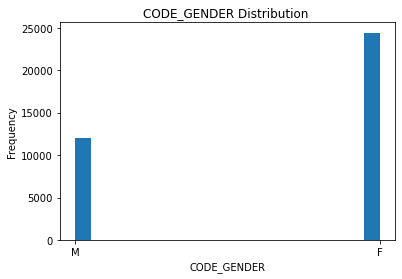

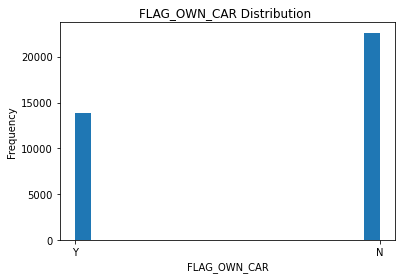

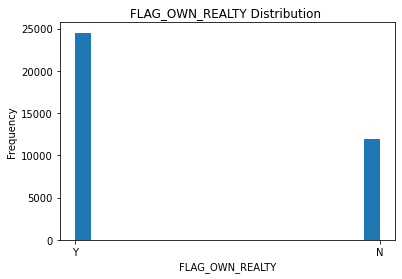

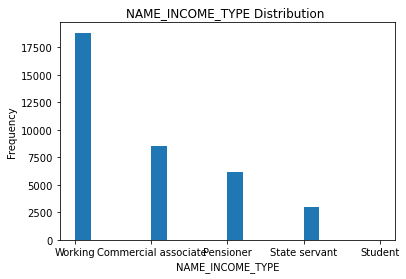

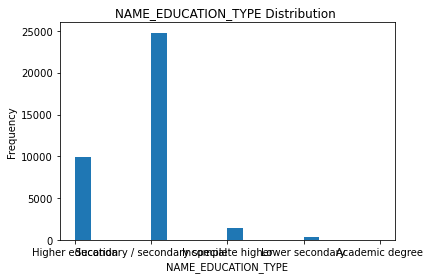

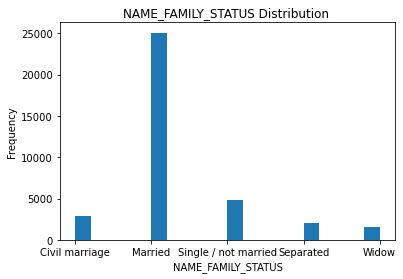

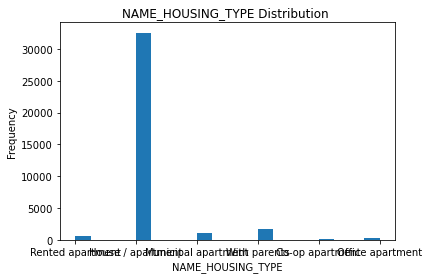

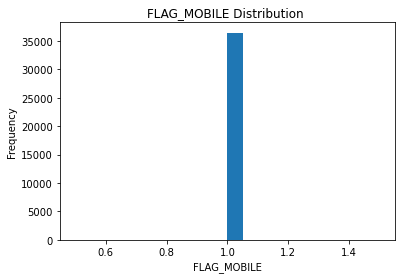

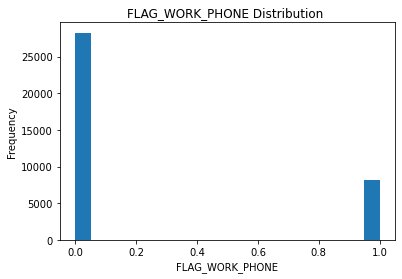

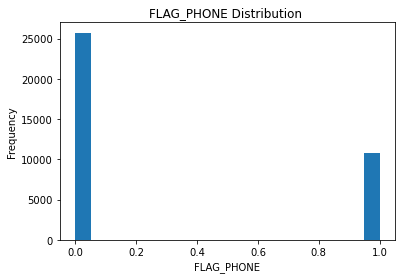

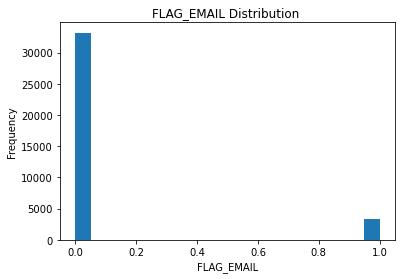

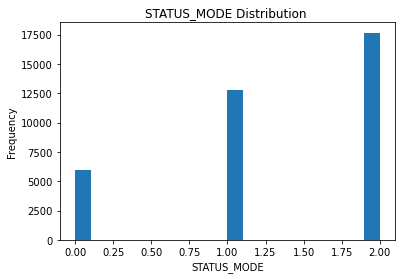

In [18]:
# Explore the balance of qualitative variables
plot_histogram(df["CODE_GENDER"], "CODE_GENDER")
plot_histogram(df["FLAG_OWN_CAR"], "FLAG_OWN_CAR")
plot_histogram(df["FLAG_OWN_REALTY"], "FLAG_OWN_REALTY")
plot_histogram(df["NAME_INCOME_TYPE"], "NAME_INCOME_TYPE")
plot_histogram(df["NAME_EDUCATION_TYPE"], "NAME_EDUCATION_TYPE")
plot_histogram(df["NAME_FAMILY_STATUS"], "NAME_FAMILY_STATUS")
plot_histogram(df["NAME_HOUSING_TYPE"], "NAME_HOUSING_TYPE")
plot_histogram(df["FLAG_MOBILE"], "FLAG_MOBILE")
plot_histogram(df["FLAG_WORK_PHONE"], "FLAG_WORK_PHONE")
plot_histogram(df["FLAG_PHONE"], "FLAG_PHONE")
plot_histogram(df["FLAG_EMAIL"], "FLAG_EMAIL")
plot_histogram(df["STATUS_MODE"], "STATUS_MODE")

# Each qualitative variable is not balanced, in particular, STATUS that rapresents
# the "behavior" of client in terms of pay or not in time the debts.

In [19]:
# Check if there are NaN values
df_na_values = df.isna()
df_na_values.sum()

# Only OCCUPATION_TYPE has got NaN values
# Let's find out how to fill the columns in a proper way

CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBILE                0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
STATUS_MODE                0
dtype: int64

In [20]:
# OCCUPATION_TYPE is a qualitative variable and rapresents the client job type
# then it is relevant for the target of model because it reveals if the client has 
# money gain.
# In this case, it is NOT possible to drop the entire column but use the mode for substitution on NaN values.

# Calculate the mode for qualitative variables
replace_occupation_type = df["OCCUPATION_TYPE"].mode()

# Fill NaN values with mode
df["OCCUPATION_TYPE"] = df["OCCUPATION_TYPE"].fillna(replace_occupation_type[0])

# Show dataframe NaN
df.isna().sum()

CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBILE            0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
STATUS_MODE            0
dtype: int64

<AxesSubplot:>

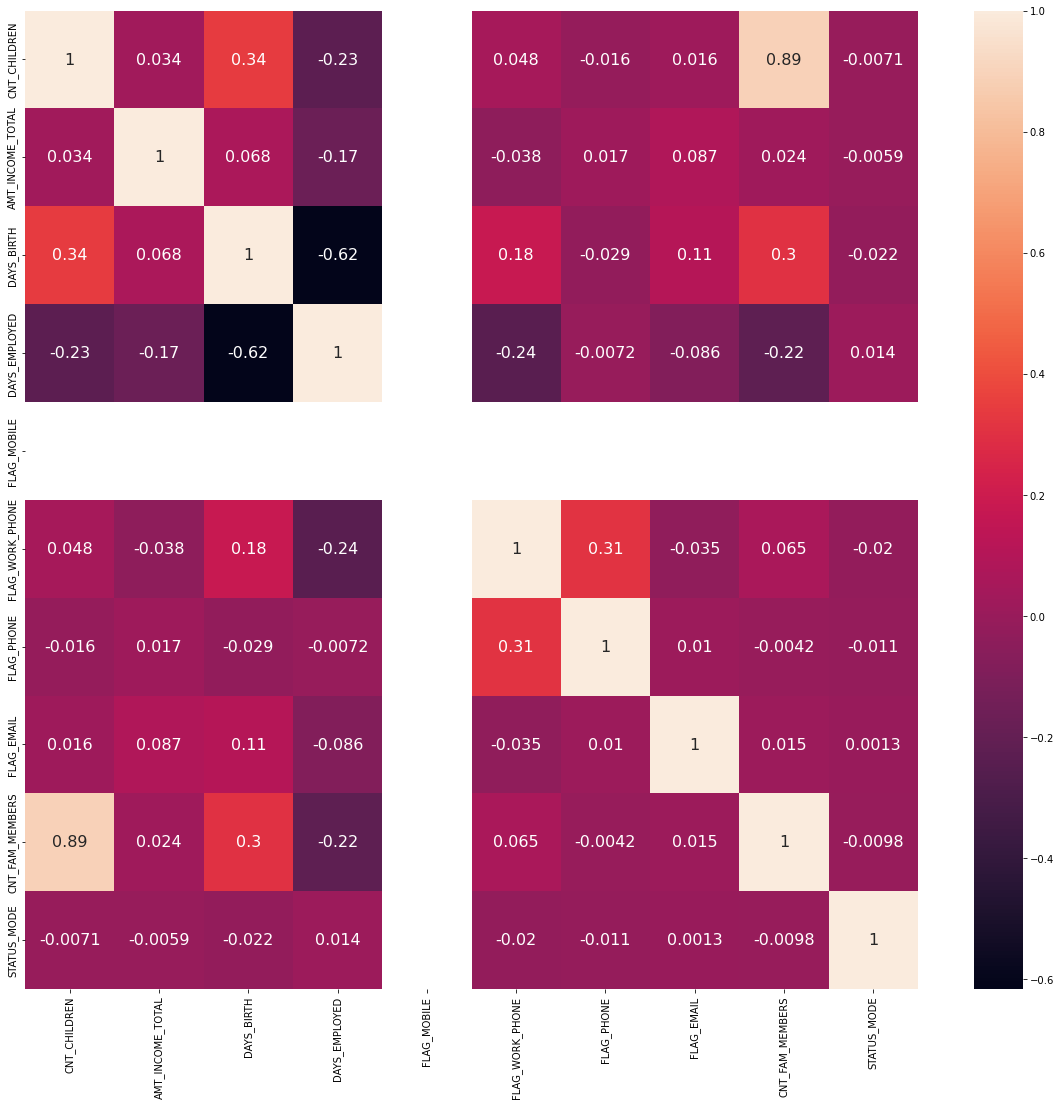

In [21]:
# Check correlation matrix in order to understand if there are multicollinearity
# and understand what features are revelant for the Response target variable
plt.figure(figsize=(20,18))
sns.heatmap(df.corr(), annot=True, annot_kws={"size":16})

# The correlation between features and target variable is very slow, and
# also correlation between features, then no strong linear correlation 
# is present between them.

# One positive linear correlation is between CNT_FAM_MEMBERS and CNT_CHILDREN
# and it is correct because more family members could be more children into family.

# FLAG_MOBILE is blank because assume only value "1" for
# all samples and then the standard deviation is equals to 0

<AxesSubplot:>

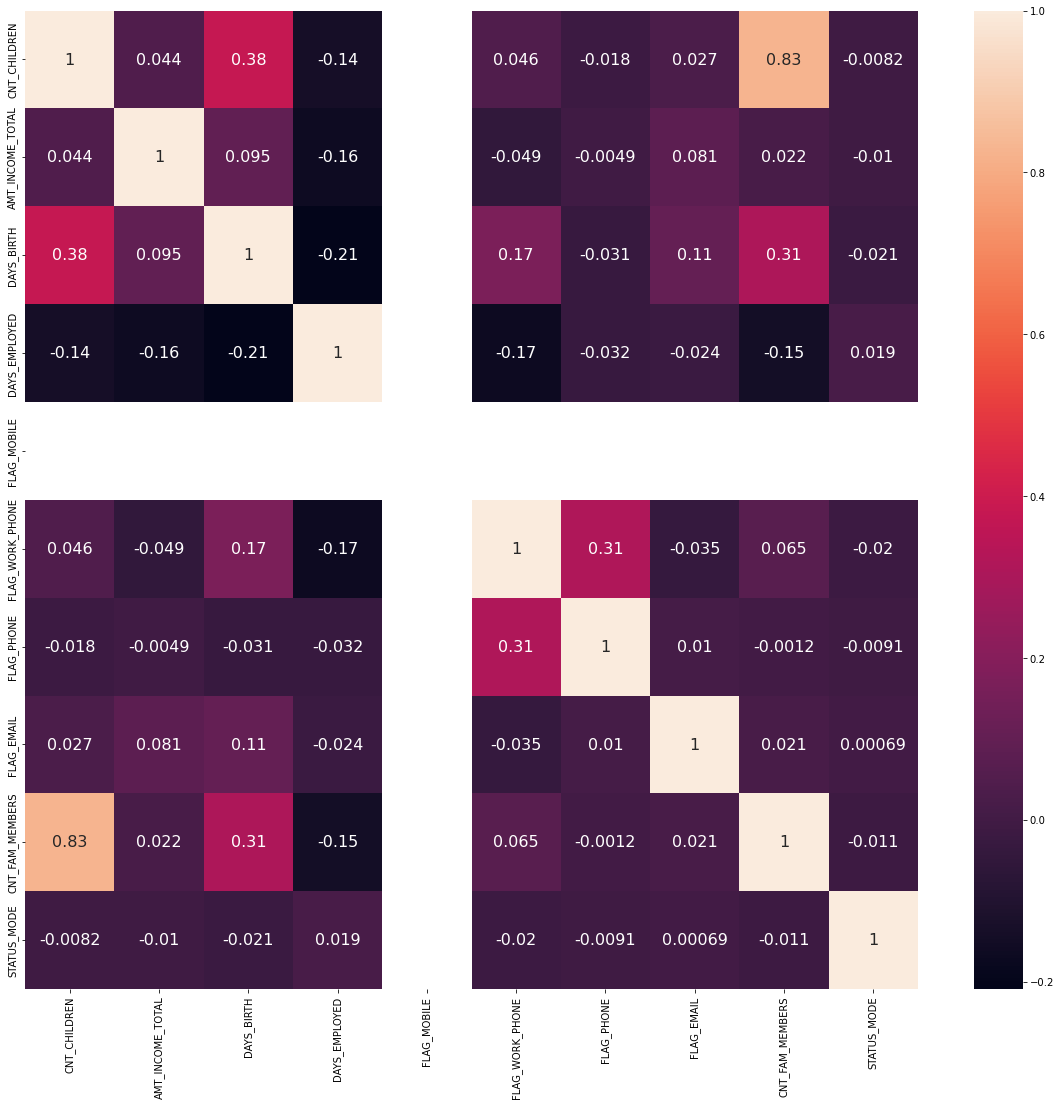

In [22]:
# Check correlation matrix with "spearman" index in order to understand
# if there are some strong monotone relationship between features and target variables
plt.figure(figsize=(20,18))
sns.heatmap(df.corr(method="spearman"), annot=True, annot_kws={"size":16})

# No revelant monotone correlation between features and target variable
# has been found, except for CNT_FAM_MEMBERS and CNT_CHILDREN already found also into Pearson correlation

In [23]:
# Let's encode qualitative variables of dataset

# For ordinal qualitative variables a Ordinal Encoder has been applied

# ordinal qualitative variables: NAME_EDUCATION_TYPE
oe = OrdinalEncoder()

# Take the numpy array from dataset and reshape it
array_edu_type = df["NAME_EDUCATION_TYPE"].values
array_edu_type = array_edu_type.reshape(-1, 1)

# Apply the ordinal encoder trasform
array_edu_type = oe.fit_transform(array_edu_type)

# Convert the classes into INT
array_edu_type = array_edu_type.astype(int)

# Substitute the encoded variable into main dataset
df["NAME_EDUCATION_TYPE"] = array_edu_type

# Show dataset
df

CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                               
5008804           M            Y               Y             0   
5008805           M            Y               Y             0   
5008806           M            Y               Y             0   
5008808           F            N               Y             0   
5008809           F            N               Y             0   
...             ...          ...             ...           ...   
5149828           M            Y               Y             0   
5149834           F            N               Y             0   
5149838           F            N               Y             0   
5150049           F            N               Y             0   
5150337           M            N               Y             0   

         AMT_INCOME_TOTAL      NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
ID                                                                     
5008804          427500.0               Working                    1   
5008805          427500.0               Working                    1   
5008806          112500.0               Working                    4   
5008808          270000.0  Commercial associate                    4   
5008809          270000.0  Commercial associate                    4   
...                   ...                   ...                  ...   
5149828          315000.0               Working                    4   
5149834          157500.0  Commercial associate                    1   
5149838          157500.0             Pensioner                    1   
5150049          283500.0               Working                    4   
5150337          112500.0               Working                    4   

           NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
ID                                                                            
5008804        Civil marriage   Rented apartment      -12005          -4542   
5008805        Civil marriage   Rented apartment      -12005          -4542   
5008806               Married  House / apartment      -21474          -1134   
5008808  Single / not married  House / apartment      -19110          -3051   
5008809  Single / not married  House / apartment      -19110          -3051   
...                       ...                ...         ...            ...   
5149828               Married  House / apartment      -17348          -2420   
5149834               Married  House / apartment      -12387          -1325   
5149838               Married  House / apartment      -12387          -1325   
5150049               Married  House / apartment      -17958           -655   
5150337  Single / not married   Rented apartment       -9188          -1193   

         FLAG_MOBILE  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
ID                                                                              
5008804            1                1           0           0        Laborers   
5008805            1                1           0           0        Laborers   
5008806            1                0           0           0  Security staff   
5008808            1                0           1           1     Sales staff   
5008809            1                0           1           1     Sales staff   
...              ...              ...         ...         ...             ...   
5149828            1                0           0           0        Managers   
5149834            1                0           1           1  Medicine staff   
5149838            1                0           1           1  Medicine staff   
5150049            1                0           0           0     Sales staff   
5150337            1                0           0           0        Laborers   

         CNT_FAM_MEMBERS  STATUS_MODE  
ID                                     
5008804              2.0            1  
5008805   

In [24]:
# For binary qualitative variables the One Ho Encoding Binary has been applied

# Binary qualitative variables: CODE_GENDER,FLAG_OWN_CAR, FLAG_OWN_REALTY
# Create encoder for qualitative variables
column_encoder = {
    'CODE_GENDER': {'M': 0, 'F': 1},
    'FLAG_OWN_CAR': {'N': 0, 'Y': 1},
    'FLAG_OWN_REALTY': {'N': 0, 'Y': 1}
}

# Invoke the function to encode qualitative variables
df = encode_binary_variables(df, column_encoder)

# Show dataset
df

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                                  
5008804            0             1                1             0   
5008805            0             1                1             0   
5008806            0             1                1             0   
5008808            1             0                1             0   
5008809            1             0                1             0   
...              ...           ...              ...           ...   
5149828            0             1                1             0   
5149834            1             0                1             0   
5149838            1             0                1             0   
5150049            1             0                1             0   
5150337            0             0                1             0   

         AMT_INCOME_TOTAL      NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
ID                                                                     
5008804          427500.0               Working                    1   
5008805          427500.0               Working                    1   
5008806          112500.0               Working                    4   
5008808          270000.0  Commercial associate                    4   
5008809          270000.0  Commercial associate                    4   
...                   ...                   ...                  ...   
5149828          315000.0               Working                    4   
5149834          157500.0  Commercial associate                    1   
5149838          157500.0             Pensioner                    1   
5150049          283500.0               Working                    4   
5150337          112500.0               Working                    4   

           NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
ID                                                                            
5008804        Civil marriage   Rented apartment      -12005          -4542   
5008805        Civil marriage   Rented apartment      -12005          -4542   
5008806               Married  House / apartment      -21474          -1134   
5008808  Single / not married  House / apartment      -19110          -3051   
5008809  Single / not married  House / apartment      -19110          -3051   
...                       ...                ...         ...            ...   
5149828               Married  House / apartment      -17348          -2420   
5149834               Married  House / apartment      -12387          -1325   
5149838               Married  House / apartment      -12387          -1325   
5150049               Married  House / apartment      -17958           -655   
5150337  Single / not married   Rented apartment       -9188          -1193   

         FLAG_MOBILE  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
ID                                                                              
5008804            1                1           0           0        Laborers   
5008805            1                1           0           0        Laborers   
5008806            1                0           0           0  Security staff   
5008808            1                0           1           1     Sales staff   
5008809            1                0           1           1     Sales staff   
...              ...              ...         ...         ...             ...   
5149828            1                0           0           0        Managers   
5149834            1                0           1           1  Medicine staff   
5149838            1                0           1           1  Medicine staff   
5150049            1                0           0           0     Sales staff   
5150337            1                0           0           0        Laborers   

         CNT_FAM_MEMBERS  STATUS_MODE  
ID                                     
5008804     

In [25]:
# For not ordinal qualitative variable the One Hot Encoding has been applied

# Not ordinal qualitative variables: NAME_INCOME_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, OCCUPATION_TYPE
# Create the list of columns
columns_list = ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

# Invoke the function to apply One Hot Encoding to a columns list
df = create_dummy_variables(df, columns_list)

# Show dataset
df

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
ID                                                                  
5008804            0             1                1             0   
5008805            0             1                1             0   
5008806            0             1                1             0   
5008808            1             0                1             0   
5008809            1             0                1             0   
...              ...           ...              ...           ...   
5149828            0             1                1             0   
5149834            1             0                1             0   
5149838            1             0                1             0   
5150049            1             0                1             0   
5150337            0             0                1             0   

         AMT_INCOME_TOTAL  NAME_EDUCATION_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
ID                                                                          
5008804          427500.0                    1      -12005          -4542   
5008805          427500.0                    1      -12005          -4542   
5008806          112500.0                    4      -21474          -1134   
5008808          270000.0                    4      -19110          -3051   
5008809          270000.0                    4      -19110          -3051   
...                   ...                  ...         ...            ...   
5149828          315000.0                    4      -17348          -2420   
5149834          157500.0                    1      -12387          -1325   
5149838          157500.0                    1      -12387          -1325   
5150049          283500.0                    4      -17958           -655   
5150337          112500.0                    4       -9188          -1193   

         FLAG_MOBILE  FLAG_WORK_PHONE  ...  OCCUPATION_TYPE_Laborers  \
ID                                     ...                             
5008804            1                1  ...                         1   
5008805            1                1  ...                         1   
5008806            1                0  ...                         0   
5008808            1                0  ...                         0   
5008809            1                0  ...                         0   
...              ...              ...  ...                       ...   
5149828            1                0  ...                         0   
5149834            1                0  ...                         0   
5149838            1                0  ...                         0   
5150049            1                0  ...                         0   
5150337            1                0  ...                         1   

         OCCUPATION_TYPE_Low-skill Laborers  OCCUPATION_TYPE_Managers  \
ID                                                                      
5008804                                   0                         0   
5008805                                   0                         0   
5008806                                   0                         0   
5008808                                   0                         0   
5008809                                   0                         0   
...                                     ...                       ...   
5149828                                   0                         1   
5149834                                   0                         0   
5149838                                   0                         0   
5150049                                   0                         0   
5150337                                   0                         0   

         OCCUPATION_TYPE_Medicine staff  \
ID                                        
5008804                               0   
5008805                               0   
5008806                               0   
5008808

In [26]:
# Show final dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 5008804 to 5150337
Data columns (total 48 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   CODE_GENDER                              36457 non-null  int64  
 1   FLAG_OWN_CAR                             36457 non-null  int64  
 2   FLAG_OWN_REALTY                          36457 non-null  int64  
 3   CNT_CHILDREN                             36457 non-null  int64  
 4   AMT_INCOME_TOTAL                         36457 non-null  float64
 5   NAME_EDUCATION_TYPE                      36457 non-null  int32  
 6   DAYS_BIRTH                               36457 non-null  int64  
 7   DAYS_EMPLOYED                            36457 non-null  int64  
 8   FLAG_MOBILE                              36457 non-null  int64  
 9   FLAG_WORK_PHONE                          36457 non-null  int64  
 10  FLAG_PHONE                            

#### Create train and test dataset

In [27]:
# Select the features without target variable
X = df.drop(["STATUS_MODE"], axis=1).values

# Select the target variables
y = df["STATUS_MODE"].values

# Split dataset in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=RANDOM_SEED)

In [28]:
# Check the shape of train and test set
print(f"Train shape - {X_train.shape} | Test shape: {X_test.shape}")

Train shape - (25519, 47) | Test shape: (10938, 47)


#### Generate synthetic data

In [29]:
# As described before, the target variable is unbalanced in terms of classes
# then a SMOTE algorithm has been used to balance it

# Fit with data extracted the SMOTE algo in order to generate synthetic data
# and balance the features with minor classes only on TRAIN set
X_train, y_train = SMOTE(sampling_strategy='auto').fit_resample(X_train, y_train)

In [30]:
# Check if the target variable has been balanced
counter = Counter(y_train)
counter

Counter({2: 12356, 0: 12356, 1: 12356})

#### Execute the standardization

In [31]:
# Execute the standardization on train and test set
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [32]:
# Check standardization
print(f"Train std: {X_train.std()} | Train mean: {X_train.mean()}")

Train std: 0.9893045053244817 | Train mean: -1.5328581544312744e-16


### Model Exploration

#### Naive Bayes models

In [33]:
# Create Bernoulli Naive Bayes model
bnb = BernoulliNB()

# Fit model with data
bnb.fit(X_train, y_train)

BernoulliNB()

In [34]:
# Print classification report for model
print(classification_report(bnb.predict(X_test), y_test))

# The Naive Bayes model have bad metrics and unbalanced between them
# in this case, this type of model, is not properly for this data

              precision    recall  f1-score   support

           0       0.40      0.18      0.25      4036
           1       0.14      0.34      0.20      1562
           2       0.51      0.50      0.51      5340

    accuracy                           0.36     10938
   macro avg       0.35      0.34      0.32     10938
weighted avg       0.42      0.36      0.37     10938



#### Support Vector Machine models

In [35]:
# Create Support Vector Machine model with kernel "rbf"
# Radial Basis Function: used for non-linear classification
svc = SVC(kernel="rbf", probability=True)

# Fit model with data
svc.fit(X_train, y_train)

SVC(probability=True)

In [36]:
# Print classification report for model
print(classification_report(svc.predict(X_test), y_test))

# The metrics on test data are too much good
# then it could be the best model for this data

              precision    recall  f1-score   support

           0       0.22      0.34      0.27      1189
           1       0.36      0.44      0.40      3116
           2       0.67      0.54      0.60      6633

    accuracy                           0.49     10938
   macro avg       0.42      0.44      0.42     10938
weighted avg       0.53      0.49      0.50     10938



#### Nearest Neighbors models

In [37]:
# Try to find out the best K value

Ks = [1,2,3,4,5,7,10,12,15,20,30,40,50]

for K in Ks:

    print("K="+str(K))
    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(X_train, y_train)

    y_pred_train = knn.predict(X_train)
    y_prob_train = knn.predict_proba(X_train)

    y_pred = knn.predict(X_test)
    y_prob = knn.predict_proba(X_test)

    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred)

    loss_train = log_loss(y_train, y_prob_train)
    loss_test = log_loss(y_test, y_prob)

    print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))
    print("LOG LOSS: TRAIN=%.4f TEST=%.4f" % (loss_train,loss_test))

# Analyzing the accuracy score and log loss metrics, the best K value for KNN model
# is: K = 2

K=1
ACCURACY: TRAIN=0.7662 TEST=0.5454
LOG LOSS: TRAIN=8.4265 TEST=16.3841
K=2
ACCURACY: TRAIN=0.7271 TEST=0.5035
LOG LOSS: TRAIN=3.7857 TEST=10.3993
K=3
ACCURACY: TRAIN=0.7441 TEST=0.5349
LOG LOSS: TRAIN=1.9084 TEST=7.3629
K=4
ACCURACY: TRAIN=0.7338 TEST=0.5254
LOG LOSS: TRAIN=1.1769 TEST=5.6949
K=5
ACCURACY: TRAIN=0.7236 TEST=0.5283
LOG LOSS: TRAIN=0.9026 TEST=4.6926
K=7
ACCURACY: TRAIN=0.6978 TEST=0.5122
LOG LOSS: TRAIN=0.7368 TEST=3.4686
K=10
ACCURACY: TRAIN=0.6649 TEST=0.4956
LOG LOSS: TRAIN=0.7175 TEST=2.4604
K=12
ACCURACY: TRAIN=0.6458 TEST=0.4867
LOG LOSS: TRAIN=0.7438 TEST=2.1083
K=15
ACCURACY: TRAIN=0.6231 TEST=0.4749
LOG LOSS: TRAIN=0.7844 TEST=1.8103
K=20
ACCURACY: TRAIN=0.5925 TEST=0.4566
LOG LOSS: TRAIN=0.8363 TEST=1.4399
K=30
ACCURACY: TRAIN=0.5552 TEST=0.4429
LOG LOSS: TRAIN=0.9025 TEST=1.1368
K=40
ACCURACY: TRAIN=0.5323 TEST=0.4318
LOG LOSS: TRAIN=0.9411 TEST=1.0840
K=50
ACCURACY: TRAIN=0.5152 TEST=0.4237
LOG LOSS: TRAIN=0.9662 TEST=1.0727


In [38]:
# K = 2 is the best number of neighbors for model
K = 3

# Create KNN model with K defined
knn = KNeighborsClassifier(n_neighbors=K)

# Fit model with data
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [39]:
# Print classification report for model
print(classification_report(knn.predict(X_test), y_test))

# The metrics on test data are not good at all
# in particular are too bad for third class of target variable

              precision    recall  f1-score   support

           0       0.47      0.35      0.40      2412
           1       0.47      0.53      0.50      3410
           2       0.60      0.62      0.61      5116

    accuracy                           0.53     10938
   macro avg       0.51      0.50      0.51     10938
weighted avg       0.53      0.53      0.53     10938



#### Logistic Regression model

In [40]:
# Create Logistic Regression model
lr = LogisticRegression()

# Fit model with data
lr.fit(X_train, y_train)

LogisticRegression()

In [41]:
# Print classification report for model
print(classification_report(lr.predict(X_test), y_test))

# Bad model for this data, it seems that model suffer 
# overfitting problem

              precision    recall  f1-score   support

           0       0.37      0.19      0.25      3590
           1       0.33      0.37      0.35      3425
           2       0.37      0.51      0.43      3923

    accuracy                           0.36     10938
   macro avg       0.36      0.35      0.34     10938
weighted avg       0.36      0.36      0.34     10938



#### K-Means model

C:\Users\39366\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\39366\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\39366\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\39366\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

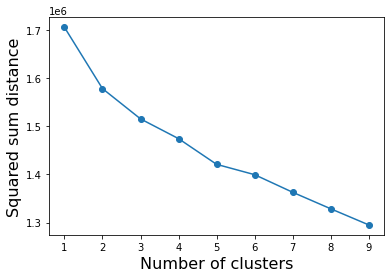

In [44]:
# Try to find out with elbow method a proper number of clusters
sse = {}
for k in range(1, 10):
    kmeans = KMeans(init="k-means++", n_clusters=k).fit(X_train)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of clusters", fontsize=16)
plt.ylabel("Squared sum distance", fontsize=16)
plt.show()

# The elbow doesn't converge than the data haven't got a defined cluster structure and then
# it is not possible to divide the data in clusters.

In [45]:
# Predict clusters
predicted_clusters = kmeans.predict(X_train)

# Calculate metrics
silhouette = silhouette_score(X_train, predicted_clusters)
calinski_harabasz = calinski_harabasz_score(X_train, predicted_clusters)
davies_bouldin = davies_bouldin_score(X_train, predicted_clusters)

# Print metrics
print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")
print(f"Davies-Bouldin Index: {davies_bouldin}")

# The Silhouette Score ranges from -1 to 1, with a higher value indicating better clustering. 
# In your case, the value is relatively low (0.103), suggesting that there might be overlaps or discrepancies between clusters.

# The Calinski-Harabasz Index measures the separation between clusters and the cohesion within each cluster. 
# A higher value indicates more coherent and separated clusters. In your case, the value is 1967.65, which can be interpreted as a good separation of clusters.

# The Davies-Bouldin Index assesses the average "similarity" between each cluster and the most similar cluster to it. 
# Lower values indicate a better partition. A value of 2.11 suggests a decent separation between clusters.

Silhouette Score: 0.11234180056494779
Calinski-Harabasz Index: 1466.7133916643832
Davies-Bouldin Index: 2.495360592257692


#### Neural Networks

In [46]:
# Create a simple Neural Network with MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100,), random_state=RANDOM_SEED)

# Fit the neural network
mlp.fit(X_train, y_train)

C:\Users\39366\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(100, 100, 100), random_state=0)

In [47]:
# Print classification report for model
print(classification_report(mlp.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.40      0.44      0.42      1643
           1       0.55      0.50      0.53      4237
           2       0.59      0.62      0.61      5058

    accuracy                           0.55     10938
   macro avg       0.52      0.52      0.52     10938
weighted avg       0.55      0.55      0.55     10938



#### Explain model predictions

In [53]:
# Invoke function to use LIME library to explain the prediction reason
explain_model_prediction(knn, sample_id=0)

In [54]:
explain_model_prediction(knn, sample_id=169)

In [55]:
explain_model_prediction(knn, sample_id=90)

## Conclusion

In conclusion, considering that the policies of the credit institution are much stricter and that customers with even just 1 or a maximum of 30 days of payment delay are considered unrealiable for credit card issuance.

In this regard, the target variable has 3 classes, which improves the performance of the model at the expense of a solution with 4 classes. According to the classification report, the best model is knn and for this reason, it has been chosen as the model for explanation using the LIME library.